## 1. Setup dan Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Load Data

In [4]:
data_path = '../data/processed/daily_trends_processed_20251221_183209.csv'

df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['keyword', 'category', 'date'])

print(f"Shape data: {df.shape}")
print(f"Rentang tanggal: {df['date'].min()} sampai {df['date'].max()}")
print(f"Jumlah keywords: {df['keyword'].nunique()}")
print(f"Jumlah categories: {df['category'].nunique()}")

df.head()

Shape data: (4600, 14)
Rentang tanggal: 2025-09-19 00:00:00 sampai 2025-12-21 00:00:00
Jumlah keywords: 50
Jumlah categories: 10


,keyword,category,region,date,interest_value,day_of_week,is_holiday,holiday_name,year,month,week,day,dayofweek,is_weekend
0,beasiswa,Education & Career,ID,2025-09-21,80,Sunday,False,NaN,2025,9,38,21,6,True
1,beasiswa,Education & Career,ID,2025-09-22,93,Monday,False,NaN,2025,9,39,22,0,False
2,beasiswa,Education & Career,ID,2025-09-23,89,Tuesday,False,NaN,2025,9,39,23,1,False
3,beasiswa,Education & Career,ID,2025-09-24,89,Wednesday,False,NaN,2025,9,39,24,2,False
4,beasiswa,Education & Career,ID,2025-09-25,86,Thursday,False,NaN,2025,9,39,25,3,False


## 3. Data Prep

- `ds`: datetime column
- `y`: target value
- `ID`: identifier for each time series (keyword-category combination)

In [6]:
prophet_df = df[['date', 'interest_value', 'keyword', 'category']].copy()
prophet_df.columns = ['ds', 'y', 'keyword', 'category']

prophet_df['ID'] = prophet_df['keyword'] + '_' + prophet_df['category']

prophet_df = prophet_df[['ds', 'y', 'ID']]

print(f"Shape data NeuralProphet: {prophet_df.shape}")
print(f"Jumlah unique IDs: {prophet_df['ID'].nunique()}")
print(f"Rentang tanggal: {prophet_df['ds'].min()} sampai {prophet_df['ds'].max()}")

prophet_df.head(10)

Shape data NeuralProphet: (4600, 3)
Jumlah unique IDs: 50
Rentang tanggal: 2025-09-19 00:00:00 sampai 2025-12-21 00:00:00


,ds,y,ID
0,2025-09-21,80,beasiswa_Education & Career
1,2025-09-22,93,beasiswa_Education & Career
2,2025-09-23,89,beasiswa_Education & Career
3,2025-09-24,89,beasiswa_Education & Career
4,2025-09-25,86,beasiswa_Education & Career
5,2025-09-26,93,beasiswa_Education & Career
6,2025-09-27,84,beasiswa_Education & Career
7,2025-09-28,80,beasiswa_Education & Career
8,2025-09-29,88,beasiswa_Education & Career
9,2025-09-30,95,beasiswa_Education & Career


## 4. Train/Test Split

In [7]:
unique_dates = sorted(prophet_df['ds'].unique())
split_idx = int(len(unique_dates) * 0.8)
train_date = unique_dates[split_idx]

train_df = prophet_df[prophet_df['ds'] < train_date].copy()
test_df = prophet_df[prophet_df['ds'] >= train_date].copy()

print(f"Train set: {train_df.shape[0]} records")
print(f"Test set: {test_df.shape[0]} records")
print(f"\nPeriode train: {train_df['ds'].min()} sampai {train_df['ds'].max()}")
print(f"Periode test: {test_df['ds'].min()} sampai {test_df['ds'].max()}")

Train set: 3710 records
Test set: 890 records

Periode train: 2025-09-19 00:00:00 sampai 2025-12-02 00:00:00
Periode test: 2025-12-03 00:00:00 sampai 2025-12-21 00:00:00


## 5. Inisialisasi NeuralProphet

In [10]:
model = NeuralProphet(
    n_forecasts=7,              
    n_lags=14,                  
    
    # Model architecture
    ar_layers=[64, 64],         
    
    # Regularization
    ar_reg=0.1,                 
    
    # Global modeling
    global_normalization=True,  
    global_time_normalization=True,
    
    # Seasonality
    yearly_seasonality=False,  
    weekly_seasonality=True,    
    daily_seasonality=False,    
    
)

print(f"Autoregressive lags: {model.n_lags} hari")
print(f"Forecast horizon: {model.n_forecasts} hari")

# Add Indonesian holidays
model.add_country_holidays(country_name='ID')


Autoregressive lags: 14 hari
Forecast horizon: 7 hari


## 6. Training Model

WARNING - (NP.forecaster.fit) - Early stopping is enabled, but regularization only starts after half the number of configured                         epochs. If you see no impact of the regularization, turn off the early_stopping or reduce the                         number of epochs to train for.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.63% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.63% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency

Train split: 2968
Val split: 742


INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.63% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.667% 

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Final training loss: 0.0097
Total epochs run: 195


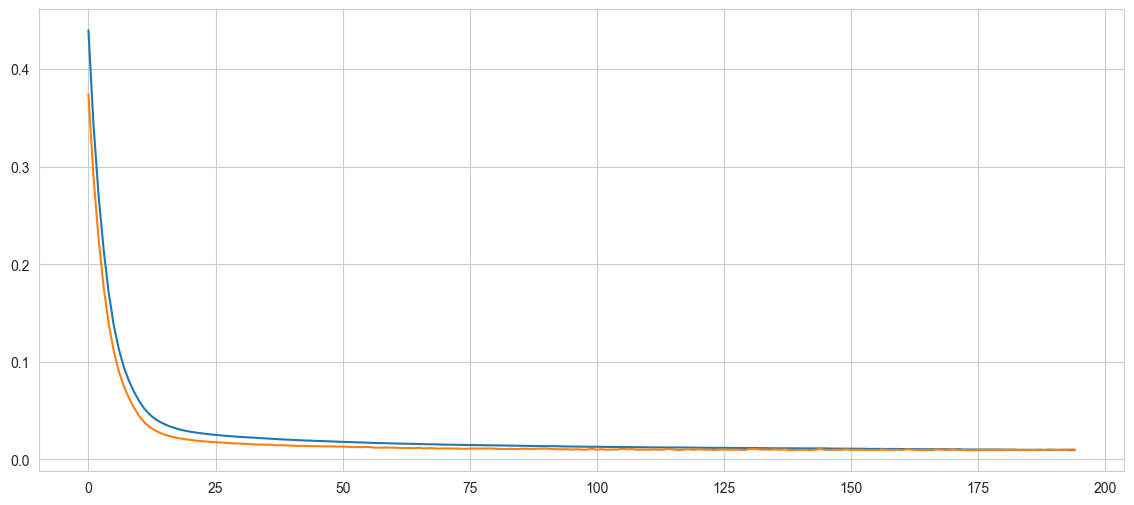

In [11]:
train_size = int(len(train_df) * 0.8)
df_train_final = train_df.iloc[:train_size].copy()
df_val = train_df.iloc[train_size:].copy()

print(f"Train split: {len(df_train_final)}")
print(f"Val split: {len(df_val)}")
print("="*70)

metrics = model.fit(
    df_train_final, 
    freq='D',             
    validation_df=df_val, 
    progress='plot',      
    
    epochs=500,
    batch_size=64,
    learning_rate=0.001,
    early_stopping=100   
)

print(f"Final training loss: {metrics['Loss'].iloc[-1]:.4f}")
print(f"Total epochs run: {len(metrics)}")


## 7. Visualisasi Training Metrics

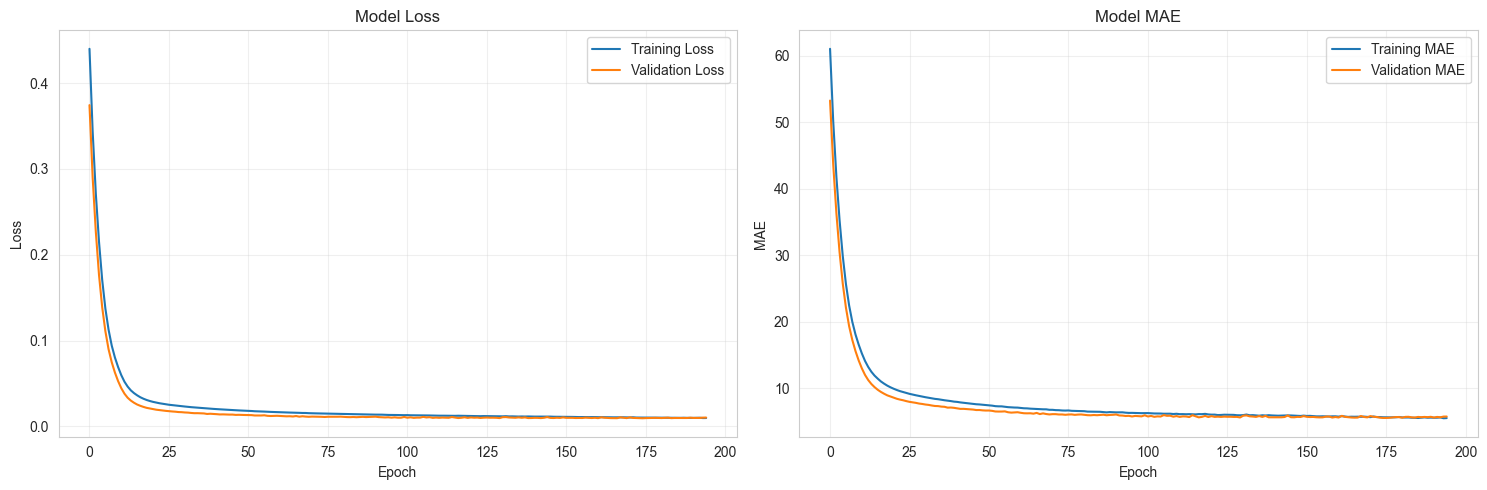

In [12]:
# Plot training metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(metrics['Loss'], label='Training Loss')
if 'Loss_val' in metrics.columns:
    axes[0].plot(metrics['Loss_val'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE (if available)
if 'MAE' in metrics.columns:
    axes[1].plot(metrics['MAE'], label='Training MAE')
    if 'MAE_val' in metrics.columns:
        axes[1].plot(metrics['MAE_val'], label='Validation MAE')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].set_title('Model MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Prediksi pada Test Set

In [13]:
full_df = pd.concat([train_df, test_df])
forecast = model.predict(full_df)

print(f"Shape forecast: {forecast.shape}")
print(f"Kolom forecast: {forecast.columns.tolist()}")

forecast.head(10)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.913% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major freq

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Shape forecast: (4600, 37)
Kolom forecast: ['ds', 'y', 'ID', 'yhat1', 'yhat2', 'yhat3', 'yhat4', 'yhat5', 'yhat6', 'yhat7', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6', 'ar7', 'trend', 'season_weekly', 'events_additive', 'event_Hari Buruh Internasional', 'event_Hari Kemerdekaan Republik Indonesia', 'event_Hari Lahir Pancasila', 'event_Hari Raya Idul Adha', 'event_Hari Raya Idul Fitri', 'event_Hari Raya Natal', 'event_Hari Raya Waisak', 'event_Hari Suci Nyepi', 'event_Hari kedua dari Hari Raya Idul Fitri', 'event_Isra Mikraj Nabi Muhammad', 'event_Kebangkitan Yesus Kristus', 'event_Kenaikan Yesus Kristus', 'event_Maulid Nabi Muhammad', 'event_Tahun Baru Imlek', 'event_Tahun Baru Islam', 'event_Tahun Baru Masehi', 'event_Wafat Yesus Kristus']


,ds,y,ID,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,...,event_Hari Suci Nyepi,event_Hari kedua dari Hari Raya Idul Fitri,event_Isra Mikraj Nabi Muhammad,event_Kebangkitan Yesus Kristus,event_Kenaikan Yesus Kristus,event_Maulid Nabi Muhammad,event_Tahun Baru Imlek,event_Tahun Baru Islam,event_Tahun Baru Masehi,event_Wafat Yesus Kristus
0,2025-09-21,80,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-09-22,93,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-09-23,89,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-09-24,89,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-09-25,86,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2025-09-26,93,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025-09-27,84,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2025-09-28,80,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2025-09-29,88,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2025-09-30,95,beasiswa_Education & Career,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 9. Extract Predictions & Ground Truth

In [14]:
# Extract predictions for evaluation
# Filter to test period only
forecast_test = forecast[forecast['ds'] >= train_date].copy()

# Get actual values
y_test = forecast_test['y'].values

# Get predictions (yhat1 is 1-step ahead forecast)
y_pred = forecast_test['yhat1'].values

# Remove NaN values (from lag initialization)
valid_mask = ~np.isnan(y_pred)
y_test_clean = y_test[valid_mask]
y_pred_clean = y_pred[valid_mask]

print(f"Test samples (after cleaning): {len(y_test_clean)}")
print(f"NaN values removed: {(~valid_mask).sum()}")

Test samples (after cleaning): 590
NaN values removed: 300


## 10. Evaluasi Model

In [17]:
# Calculate metrics
test_mae = mean_absolute_error(y_test_clean, y_pred_clean)
test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
test_r2 = r2_score(y_test_clean, y_pred_clean)
mean_actual = y_test_clean.mean()
error_pct = (test_mae / mean_actual) * 100

print("="*70)
print("HASIL EVALUASI MODEL NEURALPROPHET")
print("="*70)
print(f"\nMetrik Test:")
print(f"  MAE:      {test_mae:.4f}")
print(f"  RMSE:     {test_rmse:.4f}")
print(f"  R2:       {test_r2:.4f}")
print(f"  Error %:  {error_pct:.2f}%")


HASIL EVALUASI MODEL NEURALPROPHET

Metrik Test:
  MAE:      8.2695
  RMSE:     12.2809
  R2:       0.6566
  Error %:  12.58%


## 11. Visualisasi Prediksi

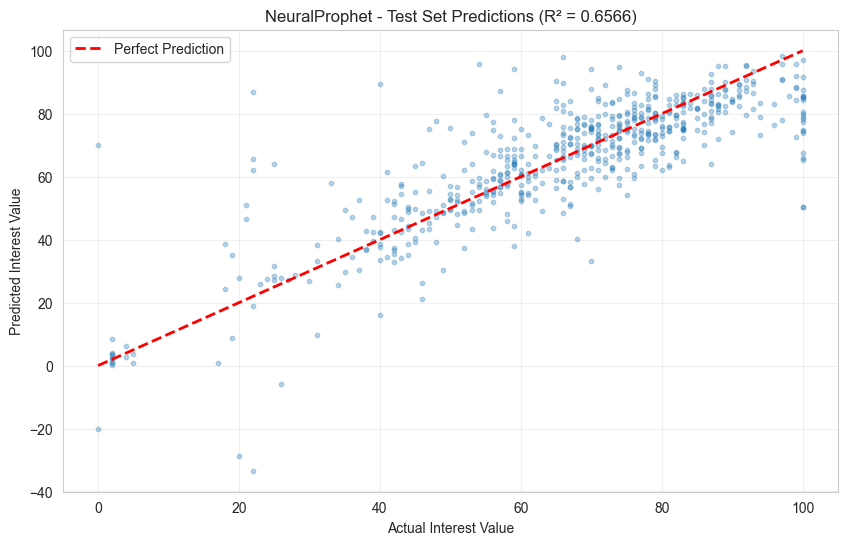

In [18]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_clean, y_pred_clean, alpha=0.3, s=10)
plt.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Interest Value')
plt.ylabel('Predicted Interest Value')
plt.title(f'NeuralProphet - Test Set Predictions (R² = {test_r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 12. Visualisasi Time Series (Sample)

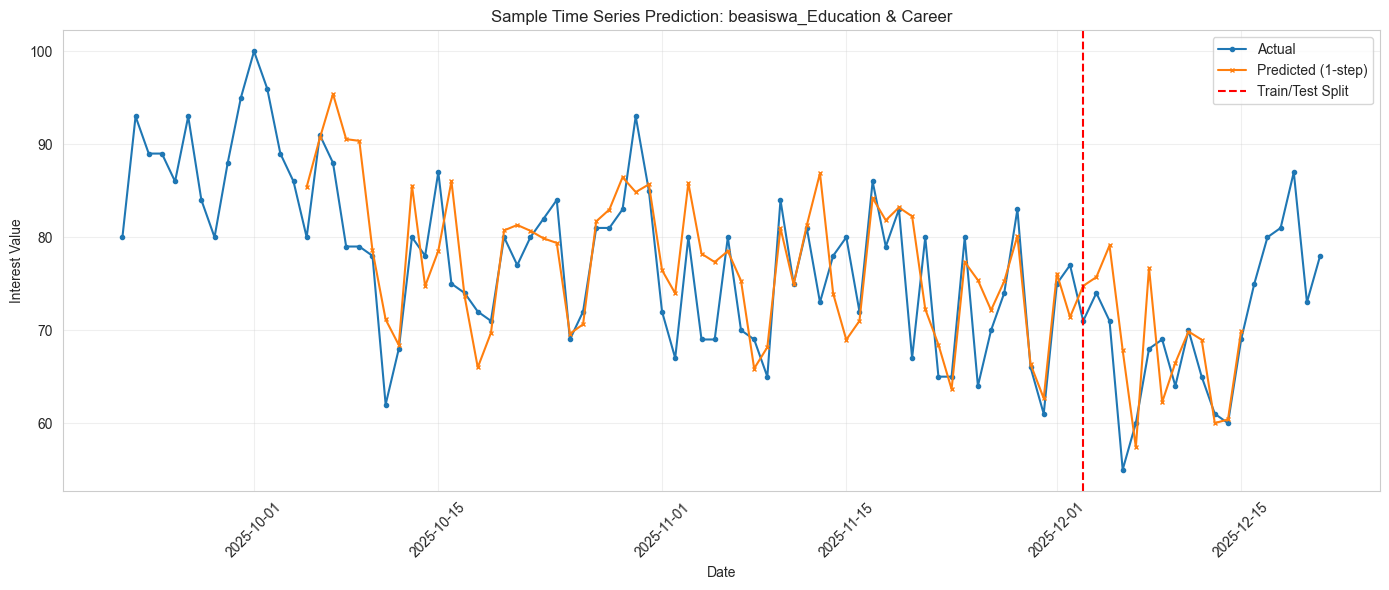

In [19]:
# Visualize predictions for a sample time series
sample_id = forecast['ID'].iloc[0]
sample_forecast = forecast[forecast['ID'] == sample_id].copy()

plt.figure(figsize=(14, 6))
plt.plot(sample_forecast['ds'], sample_forecast['y'], label='Actual', marker='o', markersize=3)
plt.plot(sample_forecast['ds'], sample_forecast['yhat1'], label='Predicted (1-step)', marker='x', markersize=3)
plt.axvline(x=train_date, color='red', linestyle='--', label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Interest Value')
plt.title(f'Sample Time Series Prediction: {sample_id}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import torch.onnx
import os

print("\n" + "="*70)
print("EXPERIMENTAL ONNX EXPORT")
print("="*70)

# Ensure models directory exists
os.makedirs('../models', exist_ok=True)

try:
    print("Attempting to export underlying PyTorch AR-Net...")
    
    # Access underlying PyTorch model
    # NeuralProphet wraps it. Usually m.model
    if not hasattr(model, 'model'):
        raise AttributeError("NeuralProphet object 'm' has no attribute 'model'")
        
    net = m.model
    net.eval()
    
    # Dummy input
    # AR-Net typically takes lags. Shape depends on configuration.
    # If n_lags=14 and n_forecasts=7
    # Input is usually (batch, n_lags)
    n_lags_val = 14 # Configured in notebook
    dummy_input = torch.randn(1, n_lags_val)
    
    onnx_path = '../models/daily/neuralprophet/onnx/neuralprophet_daily.onnx'
    
    
    torch.onnx.export(net,
                      dummy_input,
                      onnx_path,
                      input_names=['lags'],
                      output_names=['forecast'],
                      dynamic_axes={'lags' : {0 : 'batch_size'},
                                    'forecast' : {0 : 'batch_size'}})
                                    
    print(f"  ONNX model saved to: {onnx_path}")
    print("  WARNING: This is raw model export. Preprocessing (scaling) must be handled externally.")

except Exception as e:
    print(f"  ONNX Export Failed (Expected for complex NP models): {str(e)}")
    print("  Fallback: Use pickle/joblib to save the entire NeuralProphet object.")
    
    # Fallback save
    import joblib
    joblib_path = '../models/daily/neuralprophet/onnx/neuralprophet_daily.pkl'
    joblib.dump(model, joblib_path)
    print(f"  Saved full model to {joblib_path} instead.")



EXPERIMENTAL ONNX EXPORT
Attempting to export underlying PyTorch AR-Net...
  ONNX Export Failed (Expected for complex NP models): name 'm' is not defined
  Fallback: Use pickle/joblib to save the entire NeuralProphet object.
  Saved full model to ../models/daily/neuralprophet/onnx/neuralprophet_daily.pkl instead.


: 